## All of the below is going to be for region only data, no connectivity

#### Import libraries and load results

In [1]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score



#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts
import run_expts

#TS Fresh Parameter Settings
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.feature_extraction import extract_features

import matplotlib.patches as mpatches


# Set the desired precision for printing
np.set_printoptions(precision=2)

#for CM plotting at the bottom
import sklearn

#for viewing pandas dataframes in full
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))


In [2]:
region_channel_dict = constants.region_to_channel_dict
regions = list(region_channel_dict.keys())

In [3]:
data_dict = joblib.load('data_dict.pkl')

# tuned_clfs_dicts_loaded = joblib.load('region_only_no_connectivity_tuned_clfs_dicts_loaded.pkl')
tuned_results_dfs_loaded = joblib.load('region_only_no_connectivity_tuned_results_dfs_loaded.pkl')

# baseline_tuned_clfs_dicts_loaded = joblib.load('baseline_region_only_no_connectivity_tuned_clfs_dicts_loaded.pkl')
baseline_tuned_results_dfs_loaded = joblib.load('baseline_region_only_no_connectivity_tuned_results_dfs_loaded.pkl')

tuned_results_dfs_loaded = joblib.load('run_2_region_only_no_connectivity_tuned_results_dfs_loaded.pkl') #random state = 5 for clfs

#### Dummy Models - Create & Fill dataframe with results

In [4]:
dummy_model_results_dfs = joblib.load('dummy_models_results_dfs_dict.pkl')
#Create a results dataframe to populate with baseline results
df_cols = ['Expt_type_num',  'Classifier', 'EEG Type', 'Region', 'TS_Fresh_setting', 'Accuracy', 'Accuracy_std' ,'Precision', 'Recall' , 'features', 'y_true' , 'y_preds']
df_dict = {}
for col in df_cols:
     df_dict[col] = []


#___________________________________________________
data_types = ['N1','REM', 'N2', 'N3', 'Wake']
expt_nums = [1]
models = ['Dummy_uniform', 'Dummy_prior', 'Dummy_stratified']

TS_Fresh_settings = ['dummy models']

all_accs_per_fold = []

# models = ['DT', 'RF', 'Ada', 'SVC']
for data_type in data_types:
    for model in models:
        for expt_num in [1]:
            for TS_Fresh_setting in TS_Fresh_settings:
                print(data_type + ' ' + model + ' expt_' + str(expt_num) + ' ' + TS_Fresh_setting)
                results_df = dummy_model_results_dfs[data_type][model]
                
                recall_per_region = []
                precision_per_region = []
                
                mean_accs_per_region = []
                fold_accs_per_region = {}
                stds_per_region = []
                
                
                clf_name = model
                for region in regions[:13]:
                    try:
                        y_preds = results_df[region+ '_' + clf_name + '_y_preds'][0] #+ results_df[region+ '_' + clf_name + '_y_preds'][1]
                        y_true = results_df['y_true'][0] #+ results_df['y_true'][1]
                        acc_scores= [accuracy_score(y_preds, y_true) for y_preds, y_true in zip(y_preds,y_true)]
                        
                        # Calculate precision and recall _____________________
                        y_true_all = pd.concat(y_true, ignore_index=True)
                        y_preds_all = np.concatenate(y_preds)
                        prec =  precision_score(y_true_all, y_preds_all)
                        recall = recall_score(y_true_all, y_preds_all)

                        recall_per_region.append(recall) 
                        precision_per_region.append(prec)
                                            
                        fold_accs_per_region[region] = acc_scores
                        all_accs_per_fold.append(np.array(acc_scores))
                        mean_accs_per_region.append( np.array(acc_scores).mean() )
                        stds_per_region.append( np.array(acc_scores).std() )
                    except: 
                        #Some regions not done for tuned RF (took ages, decide to focus on ADA and DT)
                        print('not there!')

                df_dict['y_true'] += [y_true_all for i in range(13)]
                df_dict['y_preds'] += [y_preds_all for i in range(13)]
                        
                df_dict['Expt_type_num'] += [expt_num for i in range(13)]
                df_dict['Classifier'] += [model for i in range(13)]
                df_dict['EEG Type']+= [data_type for i in range(13)]
                df_dict['Region']+= regions 
                df_dict['TS_Fresh_setting'] += [TS_Fresh_setting for i in range(13)]
                
                df_dict['Precision'] += precision_per_region
                df_dict['Recall'] += recall_per_region
                
                df_dict['Accuracy'] += mean_accs_per_region
                df_dict['Accuracy_std'] += stds_per_region
                df_dict['features'] += ['baseline' for i in range(13)]
                
                # mean_accs_per_region
                # print(np.array(mean_accs_per_region))  
                # print(np.array(stds_per_region))  
                # print(np.array(mean_accs_per_region).max())
                # print(np.array(mean_accs_per_region).mean())

all_results_dummy_models_df = pd.DataFrame(df_dict)

N1 Dummy_uniform expt_1 dummy models
N1 Dummy_prior expt_1 dummy models
N1 Dummy_stratified expt_1 dummy models
REM Dummy_uniform expt_1 dummy models


/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/home/ko20929/.conda

REM Dummy_prior expt_1 dummy models
REM Dummy_stratified expt_1 dummy models
N2 Dummy_uniform expt_1 dummy models
N2 Dummy_prior expt_1 dummy models


/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/home/ko20929/.conda

N2 Dummy_stratified expt_1 dummy models
N3 Dummy_uniform expt_1 dummy models
N3 Dummy_prior expt_1 dummy models
N3 Dummy_stratified expt_1 dummy models
Wake Dummy_uniform expt_1 dummy models
Wake Dummy_prior expt_1 dummy models
Wake Dummy_stratified expt_1 dummy models


/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/home/ko20929/.conda

In [5]:
joblib.dump(all_results_dummy_models_df, 'all_results_dummy_models_expt_1_df.pkl')

['all_results_dummy_models_expt_1_df.pkl']

In [6]:
all_results_dummy_models_df.sort_values(by = ['Recall'], ascending = False).head(10)

,Expt_type_num,Classifier,EEG Type,Region,TS_Fresh_setting,Accuracy,Accuracy_std,Precision,Recall,features,y_true,y_preds
194,1,Dummy_stratified,Wake,Occipital,dummy models,0.533333,0.066667,0.416667,0.416667,baseline,0 0 1 0 2 0 3 1 4 1 5 ...,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, ..."
188,1,Dummy_stratified,Wake,Right Central,dummy models,0.533333,0.066667,0.416667,0.416667,baseline,0 0 1 0 2 0 3 1 4 1 5 ...,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, ..."
183,1,Dummy_stratified,Wake,Frontal,dummy models,0.533333,0.066667,0.416667,0.416667,baseline,0 0 1 0 2 0 3 1 4 1 5 ...,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, ..."
184,1,Dummy_stratified,Wake,Left Frontal,dummy models,0.533333,0.066667,0.416667,0.416667,baseline,0 0 1 0 2 0 3 1 4 1 5 ...,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, ..."
185,1,Dummy_stratified,Wake,Right Frontal,dummy models,0.533333,0.066667,0.416667,0.416667,baseline,0 0 1 0 2 0 3 1 4 1 5 ...,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, ..."
186,1,Dummy_stratified,Wake,Central,dummy models,0.533333,0.066667,0.416667,0.416667,baseline,0 0 1 0 2 0 3 1 4 1 5 ...,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, ..."
187,1,Dummy_stratified,Wake,Left Central,dummy models,0.533333,0.066667,0.416667,0.416667,baseline,0 0 1 0 2 0 3 1 4 1 5 ...,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, ..."
182,1,Dummy_stratified,Wake,Prefrontal,dummy models,0.533333,0.066667,0.416667,0.416667,baseline,0 0 1 0 2 0 3 1 4 1 5 ...,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, ..."
189,1,Dummy_stratified,Wake,Left Temporal,dummy models,0.533333,0.066667,0.416667,0.416667,baseline,0 0 1 0 2 0 3 1 4 1 5 ...,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, ..."
191,1,Dummy_stratified,Wake,Parietal,dummy models,0.533333,0.066667,0.416667,0.416667,baseline,0 0 1 0 2 0 3 1 4 1 5 ...,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, ..."


In [7]:
all_results_dummy_models_df.sort_values(by = ['Accuracy'], ascending = False).head(10)

,Expt_type_num,Classifier,EEG Type,Region,TS_Fresh_setting,Accuracy,Accuracy_std,Precision,Recall,features,y_true,y_preds
58,1,Dummy_prior,REM,Right Central,dummy models,0.65,0.093541,0.0,0.0,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
53,1,Dummy_prior,REM,Frontal,dummy models,0.65,0.093541,0.0,0.0,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
55,1,Dummy_prior,REM,Right Frontal,dummy models,0.65,0.093541,0.0,0.0,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
56,1,Dummy_prior,REM,Central,dummy models,0.65,0.093541,0.0,0.0,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
57,1,Dummy_prior,REM,Left Central,dummy models,0.65,0.093541,0.0,0.0,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
52,1,Dummy_prior,REM,Prefrontal,dummy models,0.65,0.093541,0.0,0.0,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
59,1,Dummy_prior,REM,Left Temporal,dummy models,0.65,0.093541,0.0,0.0,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
60,1,Dummy_prior,REM,Right Temporal,dummy models,0.65,0.093541,0.0,0.0,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
61,1,Dummy_prior,REM,Parietal,dummy models,0.65,0.093541,0.0,0.0,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
62,1,Dummy_prior,REM,Left Parietal,dummy models,0.65,0.093541,0.0,0.0,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


#### Single Region Baseline Model - Create & Fill dataframe with results

In [8]:
#Create a results dataframe to populate with baseline results
df_cols = ['Expt_type_num',  'Classifier', 'EEG Type', 'Region', 'TS_Fresh_setting', 'Accuracy', 'Accuracy_std' ,'Precision', 'Recall' , 'features', 'y_true' , 'y_preds']
df_dict = {}
for col in df_cols:
     df_dict[col] = []


#___________________________________________________
data_types = ['N1','REM', 'N2', 'N3', 'Wake']
expt_nums = [1,2]
models = ['DT', 'Ada']
TS_Fresh_settings = ['no_setting']

all_accs_per_fold = []

# models = ['DT', 'RF', 'Ada', 'SVC']
for data_type in data_types:
    for model in models:
        for expt_num in [1]:
            for TS_Fresh_setting in TS_Fresh_settings:
                print(data_type + ' ' + model + ' expt_' + str(expt_num) + ' ' + TS_Fresh_setting)
                results_df = baseline_tuned_results_dfs_loaded[data_type + str(expt_num) + model + TS_Fresh_setting]
                
                recall_per_region = []
                precision_per_region = []
                
                mean_accs_per_region = []
                fold_accs_per_region = {}
                stds_per_region = []
                
                
                clf_name = model
                for region in regions[:13]:
                    try:
                        y_preds = results_df[region+ '_' + clf_name + '_y_preds'][0] #+ results_df[region+ '_' + clf_name + '_y_preds'][1]
                        y_true = results_df['y_true'][0] #+ results_df['y_true'][1]
                        acc_scores= [accuracy_score(y_preds, y_true) for y_preds, y_true in zip(y_preds,y_true)]
                        
                        # Calculate precision and recall _____________________
                        y_true_all = pd.concat(y_true, ignore_index=True)
                        y_preds_all = np.concatenate(y_preds)
                        prec =  precision_score(y_true_all, y_preds_all)
                        recall = recall_score(y_true_all, y_preds_all)

                        recall_per_region.append(recall) 
                        precision_per_region.append(prec)
                                            
                        fold_accs_per_region[region] = acc_scores
                        all_accs_per_fold.append(np.array(acc_scores))
                        mean_accs_per_region.append( np.array(acc_scores).mean() )
                        stds_per_region.append( np.array(acc_scores).std() )
                    except: 
                        #Some regions not done for tuned RF (took ages, decide to focus on ADA and DT)
                        print('not there!')

                df_dict['y_true'] += [y_true_all for i in range(13)]
                df_dict['y_preds'] += [y_preds_all for i in range(13)]
                        
                df_dict['Expt_type_num'] += [expt_num for i in range(13)]
                df_dict['Classifier'] += [model for i in range(13)]
                df_dict['EEG Type']+= [data_type for i in range(13)]
                df_dict['Region']+= regions 
                df_dict['TS_Fresh_setting'] += [TS_Fresh_setting for i in range(13)]
                
                df_dict['Precision'] += precision_per_region
                df_dict['Recall'] += recall_per_region
                
                df_dict['Accuracy'] += mean_accs_per_region
                df_dict['Accuracy_std'] += stds_per_region
                df_dict['features'] += ['baseline' for i in range(13)]
                
                # mean_accs_per_region
                # print(np.array(mean_accs_per_region))  
                # print(np.array(stds_per_region))  
                # print(np.array(mean_accs_per_region).max())
                # print(np.array(mean_accs_per_region).mean())

all_results_baseline_df = pd.DataFrame(df_dict)
                

N1 DT expt_1 no_setting
N1 Ada expt_1 no_setting
REM DT expt_1 no_setting
REM Ada expt_1 no_setting
N2 DT expt_1 no_setting
N2 Ada expt_1 no_setting
N3 DT expt_1 no_setting
N3 Ada expt_1 no_setting
Wake DT expt_1 no_setting
Wake Ada expt_1 no_setting


In [9]:
joblib.dump(all_results_baseline_df, 'all_baseline_results_dataframe.pkl')

['all_baseline_results_dataframe.pkl']

#### Single Region Tuned Model Create and Fill dataframe with results

In [10]:
tuned_results_dfs_loaded = joblib.load('region_only_no_connectivity_tuned_results_dfs_loaded.pkl') #No random state for clfs 
tuned_results_dfs_loaded = joblib.load('run_2_region_only_no_connectivity_tuned_results_dfs_loaded.pkl') #random state = 5 for clfs

In [11]:
y_true_all = pd.concat(y_true, ignore_index=True)
y_preds_all = np.concatenate(y_preds)

precision_score(y_true_all, y_preds_all)
recall_score(y_true_all, y_preds_all)

0.4166666666666667

In [12]:
t1 = time.time()

df_cols = ['Expt_type_num',  'Classifier', 'EEG Type', 'Region', 'TS_Fresh_setting', 'Accuracy', 'Accuracy_std' ,'Precision', 'Recall' , 'features', 'y_true' , 'y_preds']
df_dict = {}
for col in df_cols:
     df_dict[col] = []

# Lets add in precision and recall 

data_types = ['N1','REM', 'N2', 'N3', 'Wake']
expt_nums = [1,2]
models = ['DT', 'Ada']
TS_Fresh_settings = ['Minimal', 'Efficient']

all_accs_per_fold = []

# models = ['DT', 'RF', 'Ada', 'SVC']
for data_type in data_types:
    for model in models:
        for expt_num in [1]:
            for TS_Fresh_setting in TS_Fresh_settings:
                print(data_type + ' ' + model + ' expt_' + str(expt_num) + ' ' + TS_Fresh_setting)
                results_df = tuned_results_dfs_loaded[data_type + str(expt_num) + model + TS_Fresh_setting]
                # for r_state in [0,1]:
                for r_state in [0]:
                
                    mean_accs_per_region = []
                    
                    precision_per_region = []
                    recall_per_region = []
                    
                    fold_accs_per_region = {}
                    stds_per_region = []

                    y_true_per_region = [] 
                    y_preds_per_region = []
                    
                    clf_name = model
                    for region in regions[:13]:
                    
                        try:
                            y_preds = results_df[region+ '_' + clf_name + '_y_preds'][r_state] #+ results_df[region+ '_' + clf_name + '_y_preds'][1]
                            y_true = results_df['y_true'][r_state] #+ results_df['y_true'][1]
                            acc_scores= [accuracy_score(y_preds, y_true) for y_preds, y_true in zip(y_preds,y_true)]

                            #Calculate precision and recall
                            y_true_all = pd.concat(y_true, ignore_index=True)
                            y_preds_all = np.concatenate(y_preds)
                            y_true_per_region.append(y_true_all)
                            y_preds_per_region.append(y_preds_all)

                            
                            prec =  precision_score(y_true_all, y_preds_all)
                            recall = recall_score(y_true_all, y_preds_all)

                            recall_per_region.append(recall) 
                            precision_per_region.append(prec)
                        
                            fold_accs_per_region[region] = acc_scores
                            all_accs_per_fold.append(np.array(acc_scores))
                            mean_accs_per_region.append( np.array(acc_scores).mean() )
                            stds_per_region.append( np.array(acc_scores).std() )
                            
                        except: 
                            #Some regions not done for tuned RF (took ages, decide to focus on ADA and DT)
                            print('not there!')

                
                    df_dict['y_true'] += y_true_per_region
                    df_dict['y_preds'] += y_preds_per_region
                    
                    df_dict['Expt_type_num'] += [expt_num for i in range(13)]
                    df_dict['Classifier'] += [model for i in range(13)]
                    df_dict['EEG Type']+= [data_type for i in range(13)]
                    df_dict['Region']+= regions 
                    df_dict['TS_Fresh_setting'] += [TS_Fresh_setting for i in range(13)]

                    df_dict['Precision'] += precision_per_region
                    df_dict['Recall'] += recall_per_region
                    
                    df_dict['Accuracy'] += mean_accs_per_region
                    df_dict['Accuracy_std'] += stds_per_region
                    df_dict['features'] += ['regional' for i in range(13)]
            
                    mean_accs_per_region
                    # print(np.array(mean_accs_per_region))  
                    # print(np.array(stds_per_region))  
                    # print(np.array(mean_accs_per_region).max())
                    # print(np.array(mean_accs_per_region).mean())
t2 = time.time()

all_results_df = pd.DataFrame(df_dict)

t2-t1

N1 DT expt_1 Minimal
N1 DT expt_1 Efficient
N1 Ada expt_1 Minimal
N1 Ada expt_1 Efficient
REM DT expt_1 Minimal
REM DT expt_1 Efficient
REM Ada expt_1 Minimal
REM Ada expt_1 Efficient
N2 DT expt_1 Minimal
N2 DT expt_1 Efficient
N2 Ada expt_1 Minimal
N2 Ada expt_1 Efficient
N3 DT expt_1 Minimal
N3 DT expt_1 Efficient
N3 Ada expt_1 Minimal
N3 Ada expt_1 Efficient
Wake DT expt_1 Minimal
Wake DT expt_1 Efficient
Wake Ada expt_1 Minimal
Wake Ada expt_1 Efficient


1.221344232559204

In [13]:
joblib.dump(all_results_df, 'expt_1_results_df_tuned_regional_only.pkl')

['expt_1_results_df_tuned_regional_only.pkl']

#### Plot the results for the regional model

In [14]:
all_results_baseline_df.sort_values(by = ['Recall'], ascending = False).head(5)

,Expt_type_num,Classifier,EEG Type,Region,TS_Fresh_setting,Accuracy,Accuracy_std,Precision,Recall,features,y_true,y_preds
120,1,Ada,Wake,Right Frontal,no_setting,0.600000,0.270801,0.500000,0.666667,baseline,0 0 1 0 2 0 3 1 4 1 5 ...,"[1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
117,1,Ada,Wake,Prefrontal,no_setting,0.733333,0.081650,0.700000,0.583333,baseline,0 0 1 0 2 0 3 1 4 1 5 ...,"[1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
41,1,Ada,REM,Left Frontal,no_setting,0.475000,0.145774,0.347826,0.571429,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, ..."
18,1,Ada,N1,Left Central,no_setting,0.300000,0.100000,0.275862,0.533333,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, ..."
56,1,DT,N2,Central,no_setting,0.636111,0.101074,0.500000,0.533333,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ..."


In [15]:
all_results_baseline_df.sort_values(by = ['Accuracy'], ascending = False).head(5)

,Expt_type_num,Classifier,EEG Type,Region,TS_Fresh_setting,Accuracy,Accuracy_std,Precision,Recall,features,y_true,y_preds
117,1,Ada,Wake,Prefrontal,no_setting,0.733333,0.081650,0.700000,0.583333,baseline,0 0 1 0 2 0 3 1 4 1 5 ...,"[1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
12,1,DT,N1,Occipital,no_setting,0.700000,0.169558,1.000000,0.200000,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
35,1,DT,REM,Parietal,no_setting,0.675000,0.100000,0.600000,0.214286,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
60,1,DT,N2,Right Temporal,no_setting,0.652778,0.150103,0.555556,0.333333,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ..."
30,1,DT,REM,Central,no_setting,0.650000,0.145774,0.500000,0.285714,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [16]:
expt_info = [ '1. PD vs HC', '2. (PD , PD+RBD) vs HC', '3. (PD + PD&RBD) vs HC vs RBD', 
             '4. PD vs PD+RBD vs RBD vs HC' ]

# results dataframes are these two -> all_results_df, all_results_baseline_df
# all_results_df = pd.DataFrame(df_dict)
# all_results_df.sort_values(by = ['Accuracy'], ascending = False).head(10)

In [17]:
mapping_dict = {}
for region in regions:
    mapping_dict[region] = region
    
mapping_dict['Left Frontal'] = 'L. Frontal' 
mapping_dict['Right Frontal'] = 'R. Frontal'

mapping_dict['Left Central'] = 'L. Central'
mapping_dict['Right Central'] = 'R. Central'

mapping_dict['Left Temporal'] = 'L. Temporal' 
mapping_dict['Right Temporal'] = 'R. Temporal' 

mapping_dict['Left Parietal'] = 'L. Parietal' 
mapping_dict['Right Parietal'] = 'R. Parietal'

In [18]:
# expt_results['Region'].map(mapping_dict).values

<Figure size 640x480 with 0 Axes>

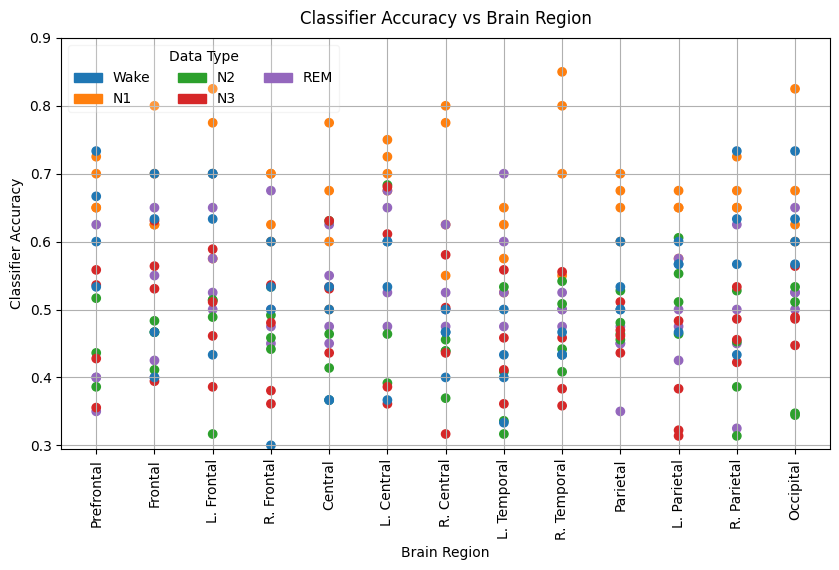

In [19]:
# for results_df in [all_results_df, all_results_baseline_df]:

for results_df in [all_results_df]:
    fig = plt.figure()
    fig = plt.figure(figsize=(8.5,5.8),dpi=100)
    
    expt_num = 1
    expt_results = results_df[results_df['Expt_type_num'] == expt_num].copy()
    expt_results.sort_values(by=['Region','Accuracy'], ascending = False)
    
    # ax = fig.add_subplot(2,2,i)
    
    plt.title('Classifier Accuracy vs Brain Region', pad = 10)
    
    #Define colours for the different data types
    colors = {'Wake':'tab:blue', 'N1':'tab:orange', 'N2':'tab:green', 'N3':'tab:red', 'REM':'tab:purple'}
    plt.scatter(expt_results['Region'].map(mapping_dict).values, expt_results['Accuracy'].values,
                    c = expt_results['EEG Type'].map(colors)) 
    
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.xlabel('Brain Region')
    plt.ylabel('Classifier Accuracy')
    plt.ylim((expt_results['Accuracy'].min() + 0.05 , expt_results['Accuracy'].max() + 0.05))
    plt.grid()
    
    plt.tight_layout()
    
    #Custom Legend, because standard legend wouldn't work for some reason
    patches = []
    for key, val in colors.items():
        patches.append(mpatches.Patch(color= val, label=key) )
    
    
    plt.legend(title = "Data Type", loc = 'upper left', ncol = 3 ,  handles=patches, framealpha = 0.2) 
    
    plt.tight_layout()
    plt.savefig('clf_accuracy_vs_region.png')

In [20]:
plt.rcParams['figure.figsize'] = (6.4, 4.8)

In [21]:
# all_results_df[ all_results_df['EEG Type'] == 'N1'].sort_values(by=['Recall'], ascending = False)

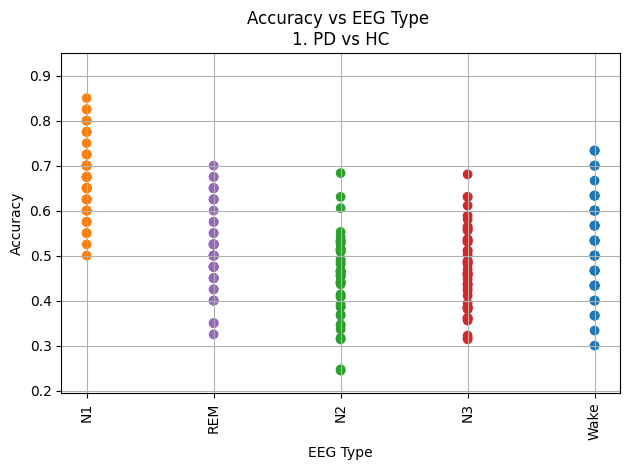

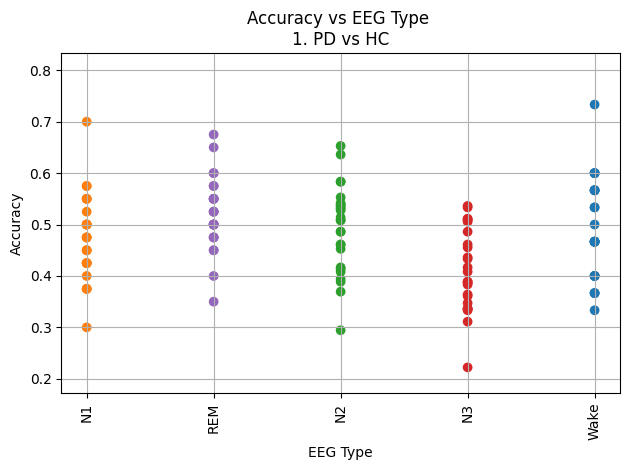

In [22]:
metric = 'Accuracy'
for results_df in [all_results_df, all_results_baseline_df]:
    fig = plt.figure()
    expt_num = 1
    expt_results = results_df[results_df['Expt_type_num'] == expt_num].copy()
    expt_results.sort_values(by=['Region','Accuracy'], ascending = False)
    
    # ax = fig.add_subplot(1,4,i)
    
    plt.title('Accuracy vs EEG Type \n' + expt_info[expt_num-1])
    
    #Define colours for the different data types
    colors = {'Wake':'tab:blue', 'N1':'tab:orange', 'N2':'tab:green', 'N3':'tab:red', 'REM':'tab:purple'}
    plt.scatter(expt_results['EEG Type'].values, expt_results['Accuracy'].values,
                    c = expt_results['EEG Type'].map(colors))
    
    
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.xlabel('EEG Type')
    plt.ylabel('Accuracy')
    plt.ylim((expt_results['Accuracy'].min() - 0.05 , expt_results['Accuracy'].max() + 0.1))
    plt.grid()
    
    plt.tight_layout()

#### Look at highest recall and highest accuracy models (highest performance)

In [23]:
all_results_dummy_models_df.sort_values(by = ['Accuracy'], ascending = False).head(10)

,Expt_type_num,Classifier,EEG Type,Region,TS_Fresh_setting,Accuracy,Accuracy_std,Precision,Recall,features,y_true,y_preds
58,1,Dummy_prior,REM,Right Central,dummy models,0.65,0.093541,0.0,0.0,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
53,1,Dummy_prior,REM,Frontal,dummy models,0.65,0.093541,0.0,0.0,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
55,1,Dummy_prior,REM,Right Frontal,dummy models,0.65,0.093541,0.0,0.0,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
56,1,Dummy_prior,REM,Central,dummy models,0.65,0.093541,0.0,0.0,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
57,1,Dummy_prior,REM,Left Central,dummy models,0.65,0.093541,0.0,0.0,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
52,1,Dummy_prior,REM,Prefrontal,dummy models,0.65,0.093541,0.0,0.0,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
59,1,Dummy_prior,REM,Left Temporal,dummy models,0.65,0.093541,0.0,0.0,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
60,1,Dummy_prior,REM,Right Temporal,dummy models,0.65,0.093541,0.0,0.0,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
61,1,Dummy_prior,REM,Parietal,dummy models,0.65,0.093541,0.0,0.0,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
62,1,Dummy_prior,REM,Left Parietal,dummy models,0.65,0.093541,0.0,0.0,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [24]:
all_results_dummy_models_df

,Expt_type_num,Classifier,EEG Type,Region,TS_Fresh_setting,Accuracy,Accuracy_std,Precision,Recall,features,y_true,y_preds
0,1,Dummy_uniform,N1,Prefrontal,dummy models,0.425000,0.127475,0.300000,0.400000,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, ..."
1,1,Dummy_uniform,N1,Frontal,dummy models,0.425000,0.127475,0.300000,0.400000,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, ..."
2,1,Dummy_uniform,N1,Left Frontal,dummy models,0.425000,0.127475,0.300000,0.400000,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, ..."
3,1,Dummy_uniform,N1,Right Frontal,dummy models,0.425000,0.127475,0.300000,0.400000,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, ..."
4,1,Dummy_uniform,N1,Central,dummy models,0.425000,0.127475,0.300000,0.400000,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, ..."
5,1,Dummy_uniform,N1,Left Central,dummy models,0.425000,0.127475,0.300000,0.400000,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, ..."
6,1,Dummy_uniform,N1,Right Central,dummy models,0.425000,0.127475,0.300000,0.400000,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, ..."
7,1,Dummy_uniform,N1,Left Temporal,dummy models,0.425000,0.127475,0.300000,0.400000,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, ..."
8,1,Dummy_uniform,N1,Right Temporal,dummy models,0.425000,0.127475,0.300000,0.400000,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, ..."
9,1,Dummy_uniform,N1,Parietal,dummy models,0.425000,0.127475,0.300000,0.400000,baseline,0 0 1 0 2 0 3 0 4 0 5 ...,"[1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, ..."


In [25]:
# all_results_dummy_models_df.sort_values(by = ['Recall', 'Accuracy'], ascending = False).head(10)

In [26]:
# all_results_df.sort_values(by = ['Recall', 'Accuracy'], ascending = False).head(10)

In [27]:
# all_results_df.sort_values(by = ['Accuracy', 'Recall'], ascending = False).head(10)

In [28]:
# plt.savefig('clf_accuracy_vs_region.png')

#### Highest Accuracy Model

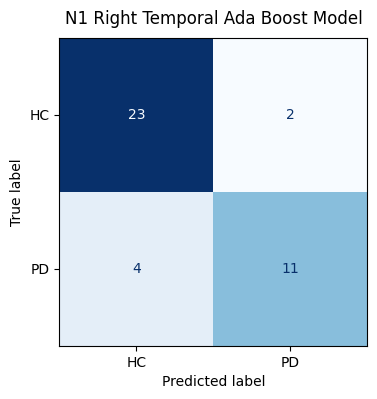

In [29]:
y_true_cm = all_results_df.sort_values(by = ['Accuracy'], ascending = False).head().iloc[0]['y_true']
y_preds_cm = all_results_df.sort_values(by = ['Accuracy'], ascending = False).head().iloc[0]['y_preds']
plt.rcParams['figure.figsize'] = (6.4, 4.8)
plt.rcParams['figure.figsize'] = (4, 4)
confusion_matrix = sklearn.metrics.confusion_matrix(y_true_cm.values, y_preds_cm, normalize = None)
# sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels = ['PD', 'HC']).plot(cmap=plt.cm.Blues)
sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels = ['HC', 'PD']).plot(colorbar=False, cmap = 'Blues')                                                                                    

plt.title('N1 Right Temporal Ada Boost Model', pad = 10)
plt.savefig('CM_1.png')

#### Highest Recall Model

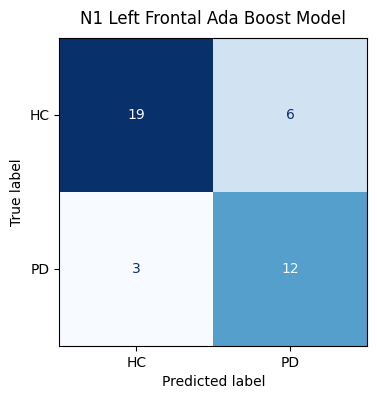

In [30]:
num = 1
y_true_cm = all_results_df.sort_values(by = ['Recall'], ascending = False).head().iloc[num]['y_true']
y_preds_cm = all_results_df.sort_values(by = ['Recall'], ascending = False).head().iloc[num]['y_preds']

region = all_results_df.sort_values(by = ['Recall'], ascending = False).head().iloc[num]['Region']
model = all_results_df.sort_values(by = ['Recall'], ascending = False).head().iloc[num]['Classifier']

confusion_matrix = sklearn.metrics.confusion_matrix(y_true_cm.values, y_preds_cm, normalize = None)
# sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels = ['PD', 'HC']).plot(cmap=plt.cm.Blues)
sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels = ['HC', 'PD']).plot(colorbar=False, cmap = 'Blues')                                                                                    

plt.title('N1 Left Frontal Ada Boost Model', pad = 10)
plt.savefig('CM_2.png')

#### Plot Feature Importances for Performance Models (Highest Acc and Highest Recall)

In [31]:
data_dict_2 = joblib.load('data_dict_2_region_only.pkl')
# Only commenting this line out because it takes ages to run and I don't want to run it again!
regional_tuned_clfs_dict = joblib.load('run_2_region_only_no_connectivity_tuned_clfs_dicts_loaded.pkl')

In [32]:
mean_importances[sorted_idx][-6:].sum()

NameError: name 'mean_importances' is not defined

In [ ]:
mean_importances.sum()

In [ ]:
X_test[[col for col in X_test.columns if region + '_' in col]].columns

In [ ]:
mean_importances[sorted_idx][-10:]

In [ ]:
best_ten_feats_right_temporal_simplified

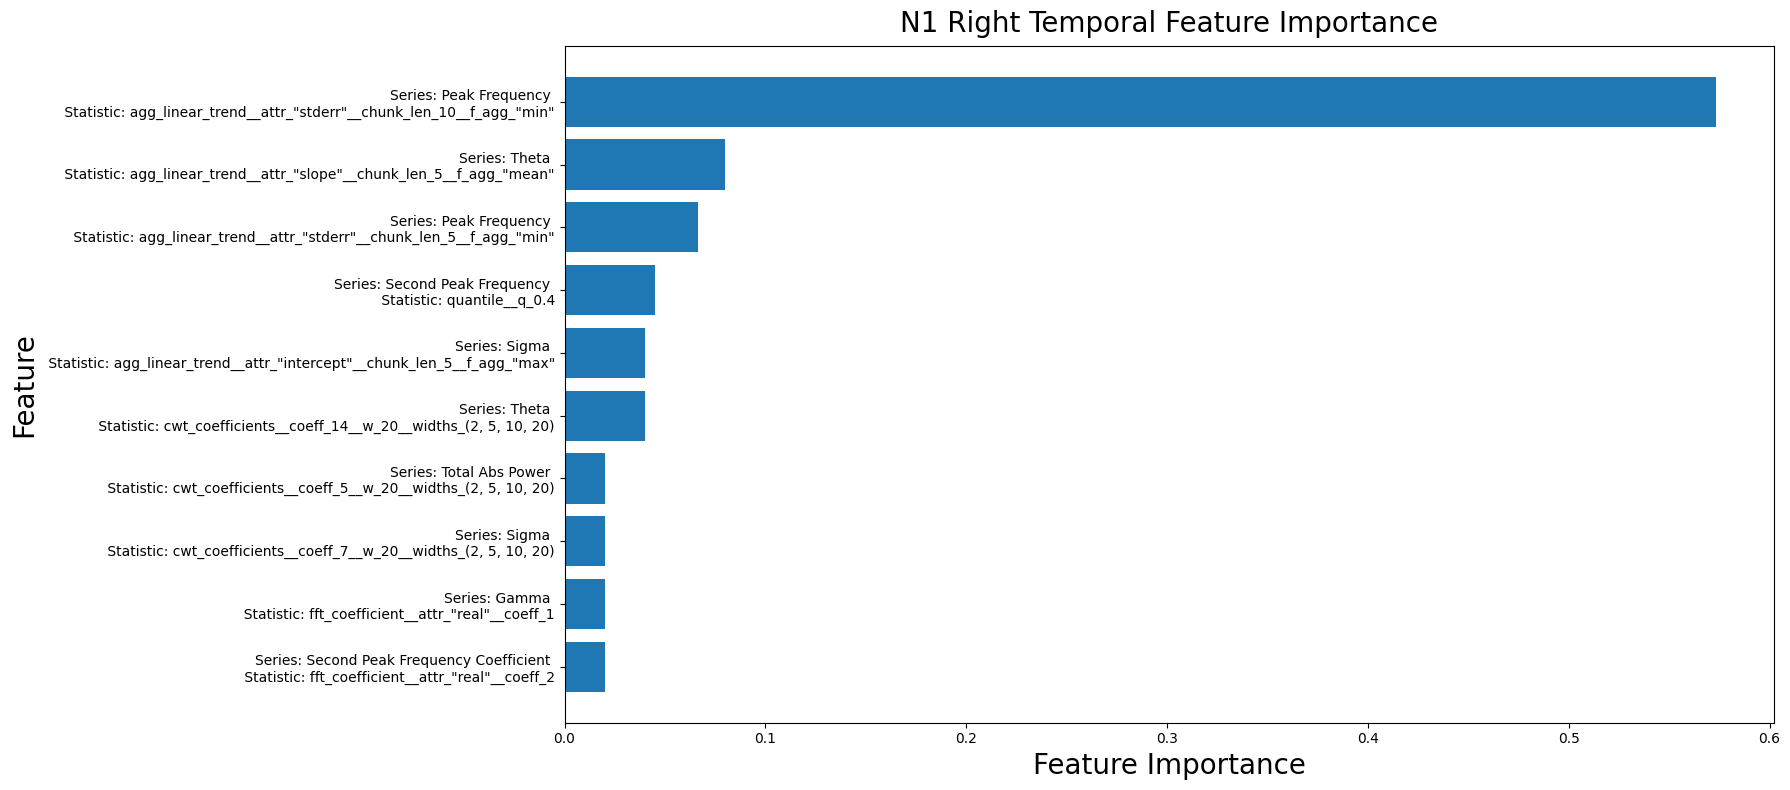

In [37]:

plt.rcParams["figure.figsize"] = (18, 8)

# for region in ['Left Frontal' , 'Right Temporal']:
for region in ['Right Temporal']:
    data_type, expt_num, model, TS_setting = 'N1','1', 'Ada', 'Efficient' #'Minimal'
    
    feature_importances = []
    
    for clf in regional_tuned_clfs_dict[data_type + expt_num + model + TS_setting][region + '_' + model][0]:
        feature_importances.append(clf.best_estimator_.feature_importances_)
    
    feature_importances_arr = np.array(feature_importances)
    mean_importances = feature_importances_arr.mean(axis = 0)
    sorted_idx = mean_importances.argsort()
    
    X_test = data_dict_2['N1']['X_'+ TS_setting]
    feature_cols = X_test[[col for col in X_test.columns if region + '_' in col]].columns
    #Plot the feature importances graph
    plt.figure()
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    plt.rcParams["figure.figsize"] = (20,10)
    plt.title('N1 Right Temporal Feature Importance', pad = 10 , fontsize=20)
    
    # Replace commas with newline characters in y-labels
    # formatted_labels = [label.replace(', ', '\n') for label in best_ten_feats_right_temporal]
    # plt.xlim([0,0.7])
    plt.barh(best_ten_feats_right_temporal , mean_importances[sorted_idx][-10:])
    # plt.barh(best_ten_feats_right_temporal_simplified , mean_importances[sorted_idx][-10:])
    plt.xlabel("Feature Importance", fontsize=20)
    plt.ylabel('Feature', fontsize=20)
    plt.tight_layout()
    plt.savefig('Feat_importance.png', dpi = 200)

In [ ]:
Series : Peak Frequency Coefficient, Statistic : agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"
'Series : Theta, Statistic :  agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean" '
Series

In [ ]:
#My attempt 
['Series: Second Peak Frequency Coefficient, Statistic: fft_coefficient__attr_"real"__coeff_2',
 'Series: Gamma,  Statistic: fft_coefficient__attr_"real"__coeff_1',
 'Series: Sigma, Statistic: cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)',
 'Series: Total Abs Power, Statistic: cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)',
 'Series: Theta, Statistic: cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)',
 'Series: Sigma, Statistic: agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"',
 'Series: Second Peak Frequency , Statistic: quantile__q_0.4',
 'Series: Peak Frequency, Statistic: 'agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"''',
 'Series: Theta Right Temporal__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"',
 'Series: Peak Frequency,  Statistic: agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"']

In [ ]:
len(best_ten_feats_right_temporal_simplified)

In [ ]:
len(best_ten_feats_right_temporal)

In [35]:
#Chat GPT Corrected the above so maybe I should double check this, or just trust it? lol 
best_ten_feats_right_temporal = ['Series: Second Peak Frequency Coefficient \n Statistic: fft_coefficient__attr_"real"__coeff_2',
 'Series: Gamma \n  Statistic: fft_coefficient__attr_"real"__coeff_1',
 'Series: Sigma \n Statistic: cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)',
 'Series: Total Abs Power \n Statistic: cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)',
 'Series: Theta \n Statistic: cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)',
 'Series: Sigma \n Statistic: agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"',
 'Series: Second Peak Frequency \n Statistic: quantile__q_0.4',
 'Series: Peak Frequency \n Statistic: agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"',
 'Series: Theta \n Statistic: agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"',
 'Series: Peak Frequency \n Statistic: agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"']

In [33]:
# Simplified  
best_ten_feats_right_temporal_simplified = ['Statistic of Second Peak Frequency Coefficient Series',
 'Statistic of Gamma Series',
 'Statistic of Sigma Series',
 'Statistic of Total Abs Power Series',
 'Statistic of Theta Series ',
 'Statistic of Sigma Series',
 'Statistic of Second Peak Frequency Series',
 'Statistic of Peak Frequency Series',
 'Statistic of Theta Series',
 'Statistic of Peak Frequency Series']

In [ ]:
print(best_ten_feats_right_temporal)

#### Chat GPT Code

In [ ]:
best_ten_feats_right_temporal = [
    'Series: Second Peak Frequency Coefficient\n Statistic: fft_coefficient__attr_"real"__coeff_2',
    'Series: Gamma\n  Statistic: fft_coefficient__attr_"real"__coeff_1',
    'Series: Sigma\n Statistic: cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)',
    'Series: Total Abs Power\n Statistic: cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)',
    'Series: Theta\n Statistic: cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)',
    'Series: Sigma\n Statistic: agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"',
    'Series: Second Peak Frequency\n Statistic: quantile__q_0.4',
    'Series: Peak Frequency\n Statistic: agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"',
    'Series: Theta \n agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"',
    'Series: Peak Frequency\n  Statistic: agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"'
]

# Sample data (replace with your actual data)
mean_importances = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
sorted_idx = range(len(mean_importances))

# Replace commas with newline characters in y-labels
formatted_labels = [label.replace(', ', '\n') for label in best_ten_feats_right_temporal]

# Plot the feature importances graph
plt.figure()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (20, 10)
plt.title(region)
plt.barh(best_ten_feats_right_temporal, mean_importances)
plt.xlabel("Feature Importance")
plt.tight_layout()

# Show the plot
plt.show()
